# Etapa 1 | Carregamento, Pré-Processamento Inicial e Divisão dos Dados

In [1]:
# ETAPA 1.0 | Bibliotecas necessárias

import os
import pandas as pd
import numpy as np
import kagglehub
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# ETAPA 1.1 | Carregar dados do Kaggle

def carregarDados(caminhoData: str) -> pd.DataFrame | None:
    """
    Carrega e unifica os arquivos CSV do Kaggle dataset
    ('time_domain', 'heart_rate_non_linear', 'frequency_domain').
    """

    dataframes = {}

    try:
        csvFiles = [f for f in os.listdir(caminhoData) if f.endswith('.csv')]

        if not csvFiles:
            print("ERRO: Nenhum arquivo CSV encontrado.")
            return None

        for fileName in csvFiles:
            fullPath = os.path.join(caminhoData, fileName)
            dfTemp = pd.read_csv(fullPath)

            keyName = fileName.split('.csv')[0]
            dataframes[keyName] = dfTemp
            print(f"✅ Carregado: {keyName} - {dfTemp.shape}")

    except Exception as e:
        print(f"Erro ao carregar: {e}")
        return None

    # Tentando identificar automaticamente quais são time / nonlinear / freq
    possiveisChaves = list(dataframes.keys())

    def buscarChave(texto):
        for key in possiveisChaves:
            if texto in key.lower():
                return key
        return None

    chaveTime = buscarChave('time')
    chaveNonLinear = buscarChave('non')
    chaveFreq = buscarChave('frequency')

    if not all([chaveTime, chaveNonLinear, chaveFreq]):
        print("ERRO: Arquivos esperados não encontrados corretamente.")
        print("Arquivos encontrados:", possiveisChaves)
        return None

    dfMerged = pd.merge(
        dataframes[chaveTime],
        dataframes[chaveNonLinear],
        on='uuid',
        how='inner'
    )

    dfFinal = pd.merge(
        dfMerged,
        dataframes[chaveFreq],
        on='uuid',
        how='inner'
    )

    print(f"\n✅ Dataset unificado com sucesso: {dfFinal.shape}")

    return dfFinal


In [3]:
# ETAPA 1.2 | Transformação inicial dos dados

def transformarDados(df: pd.DataFrame, colunaAlvo: str = 'HR'):
    """
    Separa variáveis preditoras (X) e alvo (Y),
    remove colunas irrelevantes e aplica One-Hot Encoding em 'condition'.
    """

    if df is None:
        print("ERRO: DataFrame vazio.")
        return None, None

    # Colunas que não agregam valor (apenas identificadores)
    colunasParaRemover = ['uuid', 'datasetId']

    # Variável alvo (formato coluna para álgebra linear)
    Y = df[colunaAlvo].values.reshape(-1, 1)

    # Variáveis preditoras (remove alvo + ids)
    X = df.drop(columns=[colunaAlvo] + colunasParaRemover, errors='ignore').copy()

    # One-Hot Encoding para variável categórica 'condition'
    # drop_first=True evita multicolinearidade perfeita
    if 'condition' in X.columns:
        X = pd.get_dummies(X, columns=['condition'], drop_first=True)

    return X, Y

In [4]:
# ETAPA 1.3 | Separação em treino e teste

def dividirTreinoTeste(X, Y, tamanhoTeste=0.2, estadoAleatorio=27):
    """
    Divide os dados em conjunto de treinamento e teste.
    """

    # Separação usando proporção definida (ex: 80% treino / 20% teste)
    XTrain, XTest, YTrain, YTest = train_test_split(
        X, Y, test_size=tamanhoTeste, random_state=estadoAleatorio
    )

    print(f"\n✅ Divisão do Conjunto de Dados: CONCLUÍDA!")
    print(f"   Treino: {XTrain.shape}")
    print(f"   Teste: {XTest.shape}")

    return XTrain, XTest, YTrain, YTest

In [5]:
# ETAPA 1.4 | Pré-processamento dos preditores com Yeo-Johnson seletivo

from scipy import stats

def preProcessarFeatures(XTrainRaw, XTestRaw, skewness_threshold=1.0):
    """
    Aplica transformação Yeo-Johnson APENAS às features numéricas com |skewness| > threshold.
    Features categóricas (dummies) são apenas padronizadas.
    O ajuste é feito APENAS no conjunto de treino!
    
    Args:
        XTrainRaw: Features de treino (não transformadas)
        XTestRaw: Features de teste (não transformadas)
        skewness_threshold: Limiar de assimetria (padrão: 1.0)
    """
    
    feature_names = XTrainRaw.columns
    
    # 1. Separar features numéricas e categóricas
    numeric_features = XTrainRaw.select_dtypes(include=[np.number]).columns.tolist()
    categorical_features = XTrainRaw.select_dtypes(exclude=[np.number]).columns.tolist()
    
    print(f"📊 ANÁLISE DE FEATURES")
    print("="*70)
    print(f"✅ Features numéricas: {len(numeric_features)}")
    print(f"   {numeric_features}")
    if categorical_features:
        print(f"\n📝 Features categóricas (dummies): {len(categorical_features)}")
        print(f"   {categorical_features}")
    print("="*70)
    
    # 2. Calcular skewness apenas para features numéricas
    skewness_values = np.zeros(len(feature_names))
    features_to_transform = np.zeros(len(feature_names), dtype=bool)
    
    if len(numeric_features) > 0:
        skew_vals = stats.skew(XTrainRaw[numeric_features], axis=0, nan_policy='omit')
        
        print(f"\n📊 ANÁLISE DE SKEWNESS (Features Numéricas)")
        print("="*70)
        print(f"{'Feature':<30} {'Skewness':<15} {'Transformar':<15}")
        print("-"*70)
        
        for i, feature in enumerate(feature_names):
            if feature in numeric_features:
                idx = numeric_features.index(feature)
                skewness_values[i] = skew_vals[idx]
                
                # Decidir se transforma (|skewness| > threshold)
                features_to_transform[i] = abs(skew_vals[idx]) > skewness_threshold
                transform_status = "✅ SIM" if features_to_transform[i] else "❌ NÃO"
                print(f"{feature:<30} {skew_vals[idx]:<15.4f} {transform_status:<15}")
            else:
                # Categorias não recebem valor de skewness
                print(f"{feature:<30} {'N/A (categórica)':<15} {'❌ NÃO':<15}")
        
        print("="*70)
        print(f"\n✅ {features_to_transform.sum()} de {len(numeric_features)} features numéricas serão transformadas")
        print(f"   (Threshold de skewness: ±{skewness_threshold})")
    
    # 3. Aplicar Yeo-Johnson apenas às features numéricas com alta assimetria
    XTrainTransf = XTrainRaw.copy()
    XTestTransf = XTestRaw.copy()
    
    if features_to_transform.any():
        # Selecionar apenas features que precisam transformação
        features_to_transform_cols = feature_names[features_to_transform].tolist()
        
        # Criar transformer Yeo-Johnson
        pt = PowerTransformer(method='yeo-johnson')
        
        # Ajustar APENAS no treino (evita vazamento de dados)
        XTrainTransf[features_to_transform_cols] = pt.fit_transform(
            XTrainRaw[features_to_transform_cols]
        )
        
        # Aplicar a MESMA transformação no teste
        XTestTransf[features_to_transform_cols] = pt.transform(
            XTestRaw[features_to_transform_cols]
        )
        
        print(f"\n✅ Transformação Yeo-Johnson aplicada em: {features_to_transform_cols}")
    
    # 4. Padronização (StandardScaler) para features numéricas
    # Features categóricas (dummies) já estão em escala 0-1, não precisa padronizar
    if len(numeric_features) > 0:
        scaler = StandardScaler()
        
        # Ajustar no treino e aplicar no teste
        XTrainScaled = scaler.fit_transform(XTrainTransf[numeric_features])
        XTestScaled = scaler.transform(XTestTransf[numeric_features])
        
        # Reconstrói DataFrames com features numéricas padronizadas
        XTrain = pd.DataFrame(
            XTrainScaled, 
            columns=numeric_features, 
            index=XTrainTransf.index
        )
        
        XTest = pd.DataFrame(
            XTestScaled, 
            columns=numeric_features, 
            index=XTestTransf.index
        )
        
        # Adicionar features categóricas (sem padronização)
        if categorical_features:
            XTrain[categorical_features] = XTrainTransf[categorical_features].values
            XTest[categorical_features] = XTestTransf[categorical_features].values
            # Reordenar colunas
            XTrain = XTrain[feature_names]
            XTest = XTest[feature_names]
        
        print(f"\n✅ Padronização (StandardScaler) aplicada em {len(numeric_features)} features numéricas")
        if categorical_features:
            print(f"✅ {len(categorical_features)} features categóricas mantidas sem padronização")
    else:
        XTrain = XTrainTransf
        XTest = XTestTransf
        scaler = None
        print(f"\n⚠️ Nenhuma feature numérica encontrada")
    
    return XTrain, XTest, scaler, features_to_transform, skewness_values

In [6]:
# EXECUÇÃO DA ETAPA 1 | Pipeline Completo

# 1.
path = kagglehub.dataset_download("vinayakshanawad/heart-rate-prediction-to-monitor-stress-level")
caminhoDados = os.path.join(path, 'Train Data', 'Train Data Zip')

df = carregarDados(caminhoDados)

# 2.
X, Y = transformarDados(df, colunaAlvo='HR')

# 3.
XTrainRaw, XTestRaw, YTrain, YTest = dividirTreinoTeste(
    X, Y,
    tamanhoTeste=0.2,
    estadoAleatorio=27
)

# 4. Pré-processamento com Yeo-Johnson seletivo (threshold = 1.0)
XTrain, XTest, scaler, features_transformed, skewness_vals = preProcessarFeatures(
    XTrainRaw, 
    XTestRaw, 
    skewness_threshold=1.0
)

✅ Carregado: heart_rate_non_linear_features_train - (369289, 7)
✅ Carregado: time_domain_features_train - (369289, 20)
✅ Carregado: time_domain_features_train - (369289, 20)
✅ Carregado: frequency_domain_features_train - (369289, 12)
✅ Carregado: frequency_domain_features_train - (369289, 12)

✅ Dataset unificado com sucesso: (369289, 37)

✅ Divisão do Conjunto de Dados: CONCLUÍDA!
   Treino: (295431, 35)
   Teste: (73858, 35)
📊 ANÁLISE DE FEATURES
✅ Features numéricas: 33
   ['MEAN_RR', 'MEDIAN_RR', 'SDRR', 'RMSSD', 'SDSD', 'SDRR_RMSSD', 'pNN25', 'pNN50', 'KURT', 'SKEW', 'MEAN_REL_RR', 'MEDIAN_REL_RR', 'SDRR_REL_RR', 'RMSSD_REL_RR', 'SDSD_REL_RR', 'SDRR_RMSSD_REL_RR', 'KURT_REL_RR', 'SKEW_REL_RR', 'SD1', 'SD2', 'sampen', 'higuci', 'VLF', 'VLF_PCT', 'LF', 'LF_PCT', 'LF_NU', 'HF', 'HF_PCT', 'HF_NU', 'TP', 'LF_HF', 'HF_LF']

📝 Features categóricas (dummies): 2
   ['condition_no stress', 'condition_time pressure']

✅ Dataset unificado com sucesso: (369289, 37)

✅ Divisão do Conjunto de Da

✅ Imagem salva como: yeo_johnson_transformadas.png


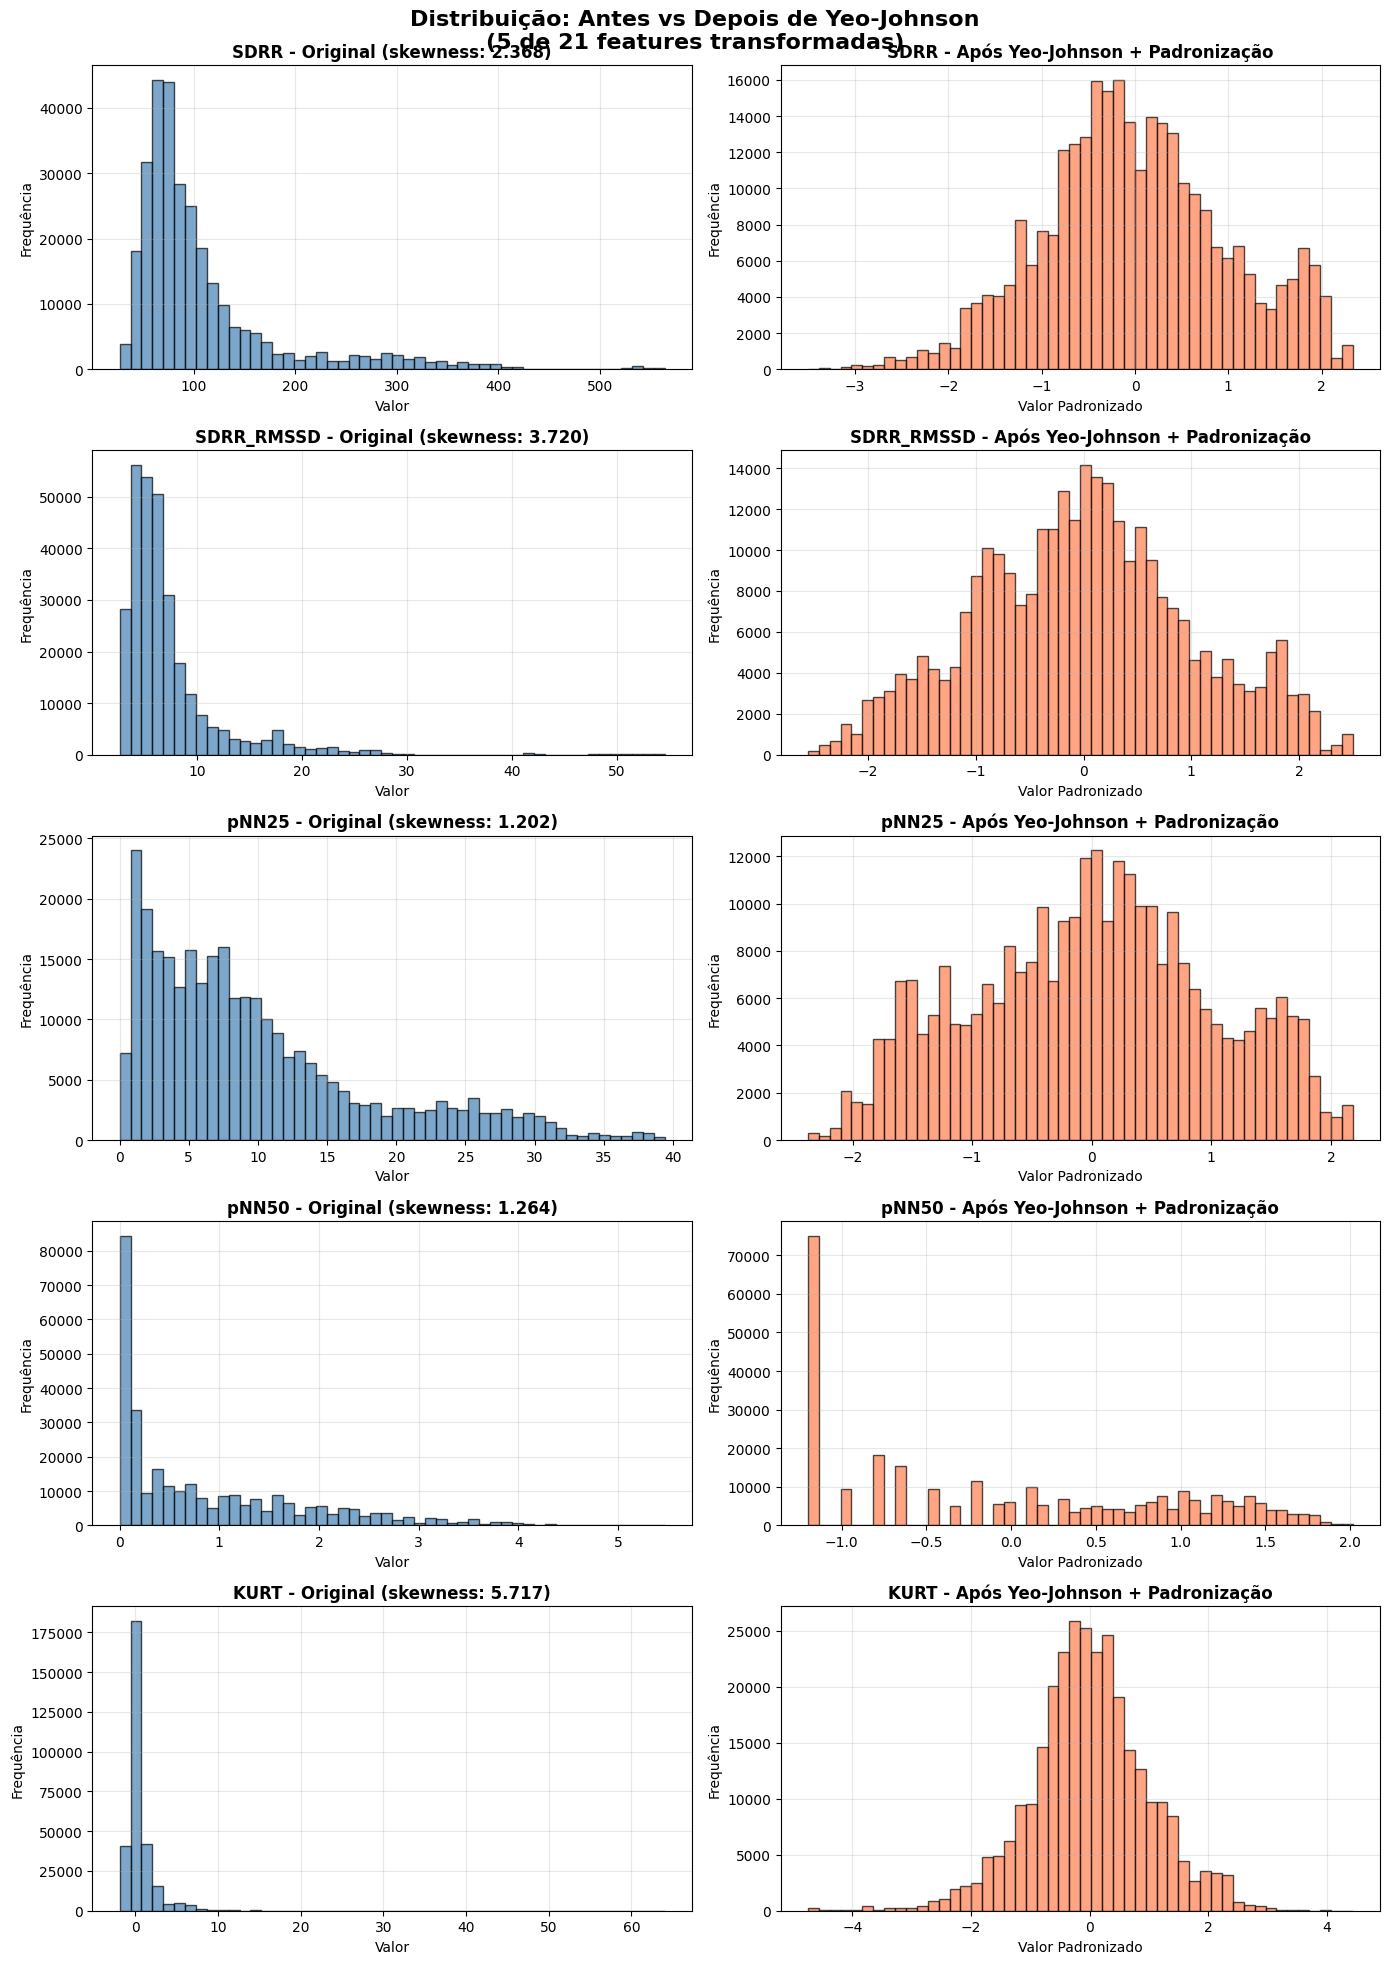


✅ Visualização completa!
   Features numéricas: 33
   Features categóricas: 2
   Total de features: 35


In [7]:
# Visualizar distribuições: Antes vs Depois (apenas features numéricas transformadas)

# Identificar features numéricas que foram transformadas
feature_names = XTrainRaw.columns
numeric_features = XTrainRaw.select_dtypes(include=[np.number]).columns.tolist()

# Features que foram transformadas (intersecção com numéricas)
transformed_features = [
    feature_names[i] 
    for i, transformed in enumerate(features_transformed) 
    if transformed and feature_names[i] in numeric_features
]

if len(transformed_features) > 0:
    # Mostrar até 5 features transformadas
    num_features_to_show = min(5, len(transformed_features))
    
    fig, axes = plt.subplots(num_features_to_show, 2, figsize=(14, 4*num_features_to_show))
    
    if num_features_to_show == 1:
        axes = axes.reshape(1, -1)
    
    fig.suptitle(f'Distribuição: Antes vs Depois de Yeo-Johnson\n({num_features_to_show} de {len(transformed_features)} features transformadas)', 
                 fontsize=16, fontweight='bold')
    
    for idx, feature in enumerate(transformed_features[:num_features_to_show]):
        # Antes (raw)
        axes[idx, 0].hist(XTrainRaw[feature], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
        skewness = skewness_vals[list(feature_names).index(feature)]
        axes[idx, 0].set_title(f'{feature} - Original (skewness: {skewness:.3f})', fontweight='bold')
        axes[idx, 0].set_xlabel('Valor')
        axes[idx, 0].set_ylabel('Frequência')
        axes[idx, 0].grid(True, alpha=0.3)
        
        # Depois (transformado + padronizado)
        axes[idx, 1].hist(XTrain[feature], bins=50, color='coral', edgecolor='black', alpha=0.7)
        axes[idx, 1].set_title(f'{feature} - Após Yeo-Johnson + Padronização', fontweight='bold')
        axes[idx, 1].set_xlabel('Valor Padronizado')
        axes[idx, 1].set_ylabel('Frequência')
        axes[idx, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Salvar a figura
    caminho_figura = 'yeo_johnson_transformadas.png'
    plt.savefig(caminho_figura, dpi=300, bbox_inches='tight')
    print(f"✅ Imagem salva como: {caminho_figura}")
    
    plt.show()
else:
    print("❌ Nenhuma feature numérica foi transformada (todas têm |skewness| ≤ 1.0)")

print(f"\n✅ Visualização completa!")
print(f"   Features numéricas: {len(numeric_features)}")
print(f"   Features categóricas: {len(XTrainRaw.select_dtypes(exclude=[np.number]).columns)}")
print(f"   Total de features: {XTrain.shape[1]}")

In [8]:
# ETAPA 1.5 | Exportar dados pré-processados em CSV

# Criar diretório para salvar dados
dados_dir = 'dados_processados'
if not os.path.exists(dados_dir):
    os.makedirs(dados_dir)
    print(f"✅ Diretório '{dados_dir}' criado")

# Salvar apenas os dados pré-processados (após Yeo-Johnson e padronização)
XTrain.to_csv(f'{dados_dir}/XTrain.csv', index=False)
XTest.to_csv(f'{dados_dir}/XTest.csv', index=False)
pd.DataFrame(YTrain, columns=['HR']).to_csv(f'{dados_dir}/YTrain.csv', index=False)
pd.DataFrame(YTest, columns=['HR']).to_csv(f'{dados_dir}/YTest.csv', index=False)

print("✅ Dados pré-processados salvos como CSV:")
print(f"   - {dados_dir}/XTrain.csv")
print(f"   - {dados_dir}/XTest.csv")
print(f"   - {dados_dir}/YTrain.csv")
print(f"   - {dados_dir}/YTest.csv")

print(f"\n📊 Resumo dos dados salvos:")
print(f"   XTrain: {XTrain.shape}")
print(f"   XTest: {XTest.shape}")
print(f"   YTrain: {YTrain.shape}")
print(f"   YTest: {YTest.shape}")
print(f"\n💾 Tamanho total: {(os.path.getsize(f'{dados_dir}/XTrain.csv') + os.path.getsize(f'{dados_dir}/XTest.csv')) / 1024 / 1024:.2f} MB")

✅ Dados pré-processados salvos como CSV:
   - dados_processados/XTrain.csv
   - dados_processados/XTest.csv
   - dados_processados/YTrain.csv
   - dados_processados/YTest.csv

📊 Resumo dos dados salvos:
   XTrain: (295431, 35)
   XTest: (73858, 35)
   YTrain: (295431, 1)
   YTest: (73858, 1)

💾 Tamanho total: 232.26 MB


## 📌 Como usar os dados pré-processados em outro notebook

### Carregar arquivos CSV
```python
import pandas as pd

# Dados pré-processados (após Yeo-Johnson seletivo e padronização)
XTrain = pd.read_csv('dados_processados/XTrain.csv')
XTest = pd.read_csv('dados_processados/XTest.csv')
YTrain = pd.read_csv('dados_processados/YTrain.csv').values
YTest = pd.read_csv('dados_processados/YTest.csv').values

print(f"Dados carregados com sucesso!")
print(f"XTrain: {XTrain.shape}")
print(f"XTest: {XTest.shape}")
```

**Nota**: Os dados brutos podem ser obtidos diretamente do dataset do Kaggle se necessário.